# Previsão de dados de preços de ações da Bovespa

## Introdução

Para uma determinada ação, temos um conjunto de valores
que determinam as variações desta ao longo do tempo que
são:

3. Preço de alta: O preço mais alto que uma ação foi
   negociada em um determinado dia.
4. Preço de baixa: O preço mais baixo que uma ação foi
   negociada em um determinado dia.
1. Preço de abertura: O preço da ação ao iniciar o pregão
   num determinado dia.
2. Preço de fechamento: O último preço em que a ação foi
   negociada antes de fechar.
5. Preço de fechamento ajustado: O preço de fechamento da
   ação depois de aplicar todos os desdobramentos e
   distribuições de dividendos. Esse é o preço real de
   fechamento da ação.
6. Volume: O volume (quantidade) de ações negociadas no dia.

O problema que temos é justamente prever esses valores para
uma determinada ação um dado número de dias após o último dia
documentado nos dados que temos.

Nesse notebook, investigamos e buscamos uma solução para
esse problema usando apenas os dados dos preços anteriores
da própria ação em si, considerando possibilidades dentro
das limitações que surgem como consequência de tal desafio.

Uma consideração importante é que há vários fatores externos
que podem causar variações nos preços de dadas ações.
Portanto, um modelo mais eficiente consideraria o contexto
específico de mercado de cada ação, e seria atualizados
através de notícias relacionadas a esse contexto, podendo
englobar um modelo de processamento de linguagem natural em
conjunto com o modelo de previsão dos preços.

## Extração, análise e processamento dos dados

Primeiramente usaremos a biblioteca investpy para encontrar as
siglas de ações da bolsa brasileira.
Para pegarmos apenas siglas válidas, filtraremos apenas as
siglas com 4 letras e 1-2 dígitos depois:

In [13]:
import investpy as inv

br = inv.stocks.get_stocks(country='brazil')
br = br[br['symbol'].str.fullmatch(r'\w{4}\d{1,2}')]['symbol']
br


0       ABCB4
1       AGRO3
2       RAIL3
3       ALPA3
4       ALPA4
        ...  
744    IBFF11
745    CVBI11
746    HRDF11
747    RSPD11
748    TCPF11
Name: symbol, Length: 713, dtype: object

Após isso, baixaremos os dados das ações usando a biblioteca
yfinance, que usa a api do yahoo finance para adquirir os dados.
Estamos adicionando '.SA' no final de cada sigla antes, para
que a busca funcione na API do yfinance, visto que as siglas na
API todas terminam com '.SA':

In [14]:
import pandas as pd
import yfinance as yf


def download(): return yf.download((br + '.SA').tolist(),
                            start='2013-01-01', end='2023-01-01')


reuse_download = True
if reuse_download:
    try:
        data = pd.read_pickle('data/downloaded.pickle')
    except FileNotFoundError:
        data = download()
        data.to_pickle('data/downloaded.pickle')
else:
    data = download()

data.head(6)


Adj Close                                         \
                    AALL34.SA AALR3.SA AAPL34.SA ABBV34.SA ABCB10.SA   
Date                                                                   
2013-01-02 00:00:00       NaN      NaN  0.107838       NaN       NaN   
2013-01-03 00:00:00       NaN      NaN  0.107838       NaN       NaN   
2013-01-04 00:00:00       NaN      NaN  0.107838       NaN       NaN   
2013-01-07 00:00:00       NaN      NaN  0.107838       NaN       NaN   
2013-01-08 00:00:00       NaN      NaN  0.107838       NaN       NaN   
2013-01-09 00:00:00       NaN      NaN  0.107838       NaN       NaN   

                                                                         ...  \
                     ABCB4.SA  ABCP11.SA   ABEV3.SA ABTT34.SA ACNB34.SA  ...   
Date                                                                     ...   
2013-01-02 00:00:00  6.294420  49.004642  11.939415  6.859639       NaN  ...   
2013-01-03 00:00:00  6.419144  47.272156  12.151094  6.859639       NaN  ...   
2013-01-04 00:00:00  6.328669  47.866150  11.950782  6.859639       NaN  ...   
2013-01-07 00:00:00  6.378431  48.262150  12.088586  6.859639       NaN  ...   
2013-01-08 00:00:00  6.446285  49.499638  12.074379  6.859639       NaN  ...   
2013-01-09 00:00:00  6.378431  49.499638  12.260489  6.859639       NaN  ...   

                       Volume                                          \
                    XPCM11.SA XPHT11.SA XPHT12.SA XPIN11.SA XPLG11.SA   
Date                                                                    
2013-01-02 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-01-03 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-01-04 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-01-07 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-01-08 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-01-09 00:00:00       NaN       NaN       NaN       NaN       NaN   

                                                                        
                    XPOM11.SA XRXB34.SA XTED11.SA YCHY11.SA   YDUQ3.SA  
Date                                                                    
2013-01-02 00:00:00       NaN       0.0       NaN       NaN  1627200.0  
2013-01-03 00:00:00       NaN       0.0       NaN       NaN  2481600.0  
2013-01-04 00:00:00       NaN       0.0       NaN       NaN   846900.0  
2013-01-07 00:00:00       NaN       0.0       NaN       NaN   850800.0  
2013-01-08 00:00:00       NaN       0.0       NaN       NaN  6316500.0  
2013-01-09 00:00:00       NaN       0.0       NaN       NaN  1665900.0  

[6 rows x 4266 columns]

### Removendo dados nulos

Agora que temos nossos dados, podemos processá-los. Primeiramente,
vamos usar um threshold para definir um máximo de valores nulos
por linha do dataset, que será 1.5x o número de nulos na linha
com menos valores nulos:

In [15]:
# Threshold
minnancol = data.isna().sum(axis=1).min()
nanthresh = len(data.columns) - 1.5 * minnancol

# Dropped rows with null values
data = data.dropna(axis=0, thresh=nanthresh)
data.head(4)

Adj Close                                           \
                      AALL34.SA   AALR3.SA AAPL34.SA ABBV34.SA ABCB10.SA   
Date                                                                       
2017-10-09 00:00:00  157.715652  16.858841  5.641909  0.881659       NaN   
2017-10-13 00:00:00  157.715652  16.779646  5.610232  0.881659       NaN   
2017-10-17 00:00:00  161.378922  16.829142  5.721101  0.874654       NaN   
2017-10-20 00:00:00  161.378922  16.581656  5.667929  0.874654       NaN   

                                                                             \
                      ABCB4.SA  ABCP11.SA   ABEV3.SA  ABTT34.SA   ACNB34.SA   
Date                                                                          
2017-10-09 00:00:00  13.856247  94.049316  18.278355  11.930856  377.209625   
2017-10-13 00:00:00  13.641062  94.049316  19.197910  12.112435  377.209625   
2017-10-17 00:00:00  13.833193  93.999809  18.868258  12.112435  381.343719   
2017-10-20 00:00:00  13.871616  60.340061  18.677406  12.112435  381.343719   

                     ...    Volume                                          \
                     ... XPCM11.SA XPHT11.SA XPHT12.SA XPIN11.SA XPLG11.SA   
Date                 ...                                                     
2017-10-09 00:00:00  ...    3617.0       NaN       NaN       NaN       NaN   
2017-10-13 00:00:00  ...    2677.0       NaN       NaN       NaN       NaN   
2017-10-17 00:00:00  ...    3147.0       NaN       NaN       NaN       NaN   
2017-10-20 00:00:00  ...    2764.0       NaN       NaN       NaN       NaN   

                                                                        
                    XPOM11.SA XRXB34.SA XTED11.SA YCHY11.SA   YDUQ3.SA  
Date                                                                    
2017-10-09 00:00:00       NaN    1000.0       NaN       NaN  2962500.0  
2017-10-13 00:00:00       NaN     100.0       NaN       NaN  2907400.0  
2017-10-17 00:00:00       NaN       0.0       NaN       NaN  3487100.0  
2017-10-20 00:00:00       NaN       0.0       NaN       NaN  2698500.0  

[4 rows x 4266 columns]

Após isso, removeremos todas as colunas que ainda tiverem algum
valor nulo, deixando apenas a parte sem valores nulos do dataset
restante:

In [16]:
d = data.loc[:, data.isna().any(axis=0)]
d = d.columns.remove_unused_levels()
data = data.drop(d.levels[1], axis=1, level=1)
data.columns = data.columns.remove_unused_levels()
data.head(4)

Adj Close                                            \
                      AALL34.SA   AALR3.SA AAPL34.SA ABBV34.SA   ABCB4.SA   
Date                                                                        
2017-10-09 00:00:00  157.715652  16.858841  5.641909  0.881659  13.856247   
2017-10-13 00:00:00  157.715652  16.779646  5.610232  0.881659  13.641062   
2017-10-17 00:00:00  161.378922  16.829142  5.721101  0.874654  13.833193   
2017-10-20 00:00:00  161.378922  16.581656  5.667929  0.874654  13.871616   

                                                                            \
                     ABCP11.SA   ABEV3.SA  ABTT34.SA   ACNB34.SA  ADHM3.SA   
Date                                                                         
2017-10-09 00:00:00  94.049316  18.278355  11.930856  377.209625  1.633761   
2017-10-13 00:00:00  94.049316  19.197910  12.112435  377.209625  1.716694   
2017-10-17 00:00:00  93.999809  18.868258  12.112435  381.343719  1.658641   
2017-10-20 00:00:00  60.340061  18.677406  12.112435  381.343719  1.691814   

                     ...     Volume                                       \
                     ...   WEGE3.SA WFCO34.SA WHRL3.SA WHRL4.SA WLMM3.SA   
Date                 ...                                                   
2017-10-09 00:00:00  ...  4853940.0     400.0   3800.0   6200.0    100.0   
2017-10-13 00:00:00  ...  6125340.0   48400.0   3300.0  11900.0      0.0   
2017-10-17 00:00:00  ...  4814420.0       0.0  11500.0  27900.0      0.0   
2017-10-20 00:00:00  ...  4334200.0       0.0      0.0    200.0      0.0   

                                                                       
                    WLMM4.SA WUNI34.SA XPCM11.SA XRXB34.SA   YDUQ3.SA  
Date                                                                   
2017-10-09 00:00:00   4000.0     300.0    3617.0    1000.0  2962500.0  
2017-10-13 00:00:00      0.0     100.0    2677.0     100.0  2907400.0  
2017-10-17 00:00:00      0.0       0.0    3147.0       0.0  3487100.0  
2017-10-20 00:00:00      0.0       0.0    2764.0       0.0  2698500.0  

[4 rows x 2940 columns]

### Tratando dados de data

Agora, precisamos fazer um tratamento dos dados.
Primeiramente, iremos mapear as datas para valores
inteiros. Por serem atributos importantes, também
extrairemos da data, colunas para ano, mês, semana
do ano, dia do ano, dia do mês, dia
da semana e trimestre:

In [17]:
# Pegando a menor data no dataset e usando ela como data inicial
dates = pd.DataFrame(data.index).apply(pd.to_datetime, utc=True).iloc[:, 0]
startDate = dates.min()

dateData = pd.DataFrame()
dateData['Day'] = (dates - startDate).dt.days
dateData['Year'] = dates.dt.year - startDate.year
dateData['Month'] = dates.dt.month # [1-12]
dateData['YearWeek'] = dates.dt.isocalendar().week.astype('int') # [1-53]
dateData['YearDay'] = dates.dt.day_of_year  # [1-366]
dateData['MonthDay'] = dates.dt.day  # [1-31]
dateData['WeekDay'] = dates.dt.day_of_week  # [0-6]
dateData['Season'] = dates.dt.quarter  # [1-4]

display(dateData.head(6))


,Day,Year,Month,YearWeek,YearDay,MonthDay,WeekDay,Season
0,0,0,10,41,282,9,0,4
1,4,0,10,41,286,13,4,4
2,8,0,10,42,290,17,1,4
3,11,0,10,42,293,20,4,4
4,17,0,10,43,299,26,3,4
5,23,0,11,44,305,1,2,4


Agora, precisamos manter as propriedades cíclicas desses valores,
considerando que o próximo valor do último valor é o valor inicial.
Por exemplo o dia do mês depois do 31 é o 1, não o 32.
Para isso, transformaremos primeiro os valores para que 0
corresponda ao valor inicial e 1 corresponda ao valor final médio
(não será o valor final, pois há casos que esse final varia, como,
por exemplo, com dias do mês que pode variar de 28 a 31). Para os
valores que começam em 0, o valor final e o inicial serão mapeados
para zero. Portanto, precisamos somar 1 a esses valores para evitar
o problema.

Para que os valores nas bordas sejam os mesmos, podemos usar um
seno ou cosseno. Usaremos os dois, considerando as propriedades
de ortogonalidade que tem entre si para completude do sistema.
O cálculo, portanto, será:

$$ x'_1 = sin \bigg(\frac{2 \pi x}{m} \bigg) $$
$$ x'_2 = cos \bigg(\frac{2 \pi x}{m} \bigg) $$

, onde $m$ é o tamanho médio do intervalo, $x$ é o valor que temos
e $x'$ o valor que queremos.

A implementação, portanto, fica:

In [18]:
import numpy as np


def create_cyclic(data, prop, cycle_size, add_one=False):
    d = (data[prop] + 1) if add_one else data[prop]
    cycle_size = cycle_size + (1 if add_one else 0)
    data[prop + '_Sin'] = np.sin(2 * np.pi * d / cycle_size)
    data[prop + '_Cos'] = np.cos(2 * np.pi * d / cycle_size)
    data.drop(prop, axis=1, inplace=True)


create_cyclic(dateData, 'Month', 12)
create_cyclic(dateData, 'YearWeek', 52)
create_cyclic(dateData, 'YearDay', 365)
create_cyclic(dateData, 'MonthDay', 31)
create_cyclic(dateData, 'WeekDay', 6, True)
create_cyclic(dateData, 'Season', 4)

display(dateData.head(6))


,Day,Year,Month_Sin,Month_Cos,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
0,0,0,-0.866025,0.500000,-0.970942,0.239316,-0.989932,0.141540,0.968077,-0.250653,0.781831,0.623490,-2.449294e-16,1.0
1,4,0,-0.866025,0.500000,-0.970942,0.239316,-0.977848,0.209315,0.485302,-0.874347,-0.974928,-0.222521,-2.449294e-16,1.0
2,8,0,-0.866025,0.500000,-0.935016,0.354605,-0.961130,0.276097,-0.299363,-0.954139,0.974928,-0.222521,-2.449294e-16,1.0
3,11,0,-0.866025,0.500000,-0.935016,0.354605,-0.945596,0.325342,-0.790776,-0.612106,-0.974928,-0.222521,-2.449294e-16,1.0
4,17,0,-0.866025,0.500000,-0.885456,0.464723,-0.907014,0.421101,-0.848644,0.528964,-0.433884,-0.900969,-2.449294e-16,1.0
5,23,0,-0.500000,0.866025,-0.822984,0.568065,-0.858764,0.512371,0.201299,0.979530,0.433884,-0.900969,-2.449294e-16,1.0


Agora, precisamos normalizar os dados, para que estes
possam ser processados pelo modelo.

Primeiramente, para as datas ainda não escaladas, iremos
definir uma data final, para escalar os valores de data
para dentro do intervalo:

In [19]:
# Um ano depois da última data
endDate = dates.max() + pd.offsets.DateOffset(years=1)

dateData['Year'] = dateData['Year'] / (endDate.year - startDate.year)
dateData['Day'] = dateData['Day'] / (endDate - startDate).days

display(dateData.head(6))

,Day,Year,Month_Sin,Month_Cos,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
0,0.000000,0.0,-0.866025,0.500000,-0.970942,0.239316,-0.989932,0.141540,0.968077,-0.250653,0.781831,0.623490,-2.449294e-16,1.0
1,0.001761,0.0,-0.866025,0.500000,-0.970942,0.239316,-0.977848,0.209315,0.485302,-0.874347,-0.974928,-0.222521,-2.449294e-16,1.0
2,0.003521,0.0,-0.866025,0.500000,-0.935016,0.354605,-0.961130,0.276097,-0.299363,-0.954139,0.974928,-0.222521,-2.449294e-16,1.0
3,0.004842,0.0,-0.866025,0.500000,-0.935016,0.354605,-0.945596,0.325342,-0.790776,-0.612106,-0.974928,-0.222521,-2.449294e-16,1.0
4,0.007482,0.0,-0.866025,0.500000,-0.885456,0.464723,-0.907014,0.421101,-0.848644,0.528964,-0.433884,-0.900969,-2.449294e-16,1.0
5,0.010123,0.0,-0.500000,0.866025,-0.822984,0.568065,-0.858764,0.512371,0.201299,0.979530,0.433884,-0.900969,-2.449294e-16,1.0


### Tratando dados de preços

Agora, vamos tratar os dados de preços das ações. Iremos
primeiramente inverter os níveis do dataframe, deixando as ações
como índice principal das colunas:

In [20]:
priceData = data.copy().swaplevel(axis=1)
priceData.head(4)


,AALL34.SA,AALR3.SA,AAPL34.SA,ABBV34.SA,ABCB4.SA,ABCP11.SA,ABEV3.SA,ABTT34.SA,ACNB34.SA,ADHM3.SA,...,WEGE3.SA,WFCO34.SA,WHRL3.SA,WHRL4.SA,WLMM3.SA,WLMM4.SA,WUNI34.SA,XPCM11.SA,XRXB34.SA,YDUQ3.SA
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,...,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-09 00:00:00,157.715652,16.858841,5.641909,0.881659,13.856247,94.049316,18.278355,11.930856,377.209625,1.633761,...,4853940.0,400.0,3800.0,6200.0,100.0,4000.0,300.0,3617.0,1000.0,2962500.0
2017-10-13 00:00:00,157.715652,16.779646,5.610232,0.881659,13.641062,94.049316,19.197910,12.112435,377.209625,1.716694,...,6125340.0,48400.0,3300.0,11900.0,0.0,0.0,100.0,2677.0,100.0,2907400.0
2017-10-17 00:00:00,161.378922,16.829142,5.721101,0.874654,13.833193,93.999809,18.868258,12.112435,381.343719,1.658641,...,4814420.0,0.0,11500.0,27900.0,0.0,0.0,0.0,3147.0,0.0,3487100.0
2017-10-20 00:00:00,161.378922,16.581656,5.667929,0.874654,13.871616,60.340061,18.677406,12.112435,381.343719,1.691814,...,4334200.0,0.0,0.0,200.0,0.0,0.0,0.0,2764.0,0.0,2698500.0


Por hora, também iremos limitar o tamanho do dataset, para acelerar
os cálculos e o treinamento:

In [21]:
numstocksused = 100

stocks = data.columns.levels[1]
stocks = stocks[:numstocksused]
priceData = priceData[stocks]
priceData.shape

(1258, 600)

Agora,  escalar os dados para que fiquem entre -1 e 1.
Criaremos uma lista de MinMaxScaler, usando um scaler diferente
para cada ação, visto que a distribuição de preços muda para
cada ação.

Também escalaremos os valores para o intervalo de -0.96 a 0.96.
Os 0.04 sobrando em cada lado servirão como margens caso apareçam
valores maiores ou menores que os limites atuais em dados futuros:

In [22]:
from sklearn.preprocessing import MinMaxScaler

minMaxMargin = 0.04  # Margem de erro
scalers = [MinMaxScaler((-1 + minMaxMargin, 1 - minMaxMargin)) for _ in stocks]

for st, sc in zip(stocks, scalers):
    priceData[st] = sc.fit_transform(priceData[st])

priceData.head(4)


AALL34.SA                                          \
                    Adj Close     Close      High       Low      Open   
Date                                                                    
2017-10-09 00:00:00  0.597213  0.605022  0.605022  0.605022  0.605022   
2017-10-13 00:00:00  0.597213  0.605022  0.605022  0.605022  0.605022   
2017-10-17 00:00:00  0.649927  0.657385  0.657385  0.657385  0.657385   
2017-10-20 00:00:00  0.649927  0.657385  0.657385  0.657385  0.657385   

                               AALR3.SA                                ...  \
                       Volume Adj Close     Close      High       Low  ...   
Date                                                                   ...   
2017-10-09 00:00:00 -0.949563  0.163574  0.167660  0.161074  0.190176  ...   
2017-10-13 00:00:00 -0.960000  0.153236  0.157303  0.135302  0.178453  ...   
2017-10-17 00:00:00 -0.960000  0.159697  0.163776  0.135302  0.184966  ...   
2017-10-20 00:00:00 -0.960000  0.127390  0.131409  0.135302  0.179756  ...   

                    CBOP11.SA                                CCRO3.SA  \
                         High       Low      Open    Volume Adj Close   
Date                                                                    
2017-10-09 00:00:00  0.162632  0.226389  0.168882 -0.938535  0.288426   
2017-10-13 00:00:00  0.162632  0.234184  0.176679 -0.949583  0.405419   
2017-10-17 00:00:00  0.162632  0.229836  0.176718 -0.943922  0.442644   
2017-10-20 00:00:00  0.162632  0.195055  0.176679 -0.951591  0.467369   

                                                                       
                        Close      High       Low      Open    Volume  
Date                                                                   
2017-10-09 00:00:00  0.552393  0.569546  0.570811  0.580428 -0.943661  
2017-10-13 00:00:00  0.690885  0.701849  0.710270  0.667413 -0.887382  
2017-10-17 00:00:00  0.734951  0.763160  0.732973  0.752817 -0.858443  
2017-10-20 00:00:00  0.695607  0.745412  0.749189  0.759143 -0.900813  

[4 rows x 600 columns]

Agora, também podemos usar o onehot encoder para especificar
qual das ações está associada a um dado específico que o modelo
irá usar:

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(handle_unknown='ignore')
ohenc.fit(np.array(stocks).reshape(len(stocks), -1))
display(ohenc.categories_[0][:10])


array(['AALL34.SA', 'AALR3.SA', 'AAPL34.SA', 'ABBV34.SA', 'ABCB4.SA',
       'ABCP11.SA', 'ABEV3.SA', 'ABTT34.SA', 'ACNB34.SA', 'ADHM3.SA'],
      dtype=object)

## Treinando o modelo

Agora, iremos treinar nosso modelo.
Primeiramente, iremos transformar o dataset de forma
que ele possa ser usado pelo nosso modelo.
Para isso, iremos usar o conceito de lookback, que
define uma janela de quantos dias para trás o dataset
deve considerar em cada iteração do treino.

Iremos criar um array em que cada posição será um bloco
de dados considerando os n dias anteriores. O array de
resultados para prever terá para cada bloco de dados
desses o dia atual que deve ser previsto.
Usaremos um lookback de 4, considerando 4 dias anteriores.

Separaremos os 70% iniciais dos dados para treino e os 30%
restantes para teste:

In [12]:
from tensorflow.signal import fft, ifft


def createDataset(specificData, universalData, stocks, ohenc, predictFeats, lookBack):
    datasize = len(specificData)-lookBack
    dataX, dataY = [], []
    
    stockLabels = np.tile(stocks.to_numpy(), datasize)
    for i in range(datasize):
        a = specificData.iloc[i : i + lookBack, :]
        b = universalData.iloc[i : i + lookBack, :]
        
        for j, st in enumerate(stocks):
            c = np.repeat(ohenc.transform(
                [[st]]).todense(), lookBack, axis=0)
            d = np.concatenate([a[st], b, pd.DataFrame(c)], axis=1)
            dataX.append(d)
            dataY.append(
                specificData.iloc[i + lookBack, :].loc[st].loc[predictFeats])

    return np.array(dataX), np.array(dataY), stockLabels


trainSize = int(len(priceData) * 0.7)
trainSet = priceData.iloc[:trainSize, :]
testSet = priceData.iloc[trainSize:, :]
trainDate = dateData.iloc[:trainSize, :]
testDate = dateData.iloc[trainSize:, :]
print(len(trainSet), len(testSet))

lookBack = 4
predictFeats = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

trainX, trainY, trainSL = createDataset(
    trainSet, trainDate, stocks, ohenc, predictFeats, lookBack)
testX, testY, testSL = createDataset(
    testSet, testDate, stocks, ohenc, predictFeats, lookBack)


2023-07-11 15:26:01.212046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 15:26:02.096635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


880 378


KeyboardInterrupt: 

Agora que preparamos os dados para treino,
podemos criar e treinar nosso modelo:

In [73]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow import keras
from keras import layers

set_seed(42)

pcols = len(priceData[stocks[0]].columns)
dtcols = len(dateData.columns)

model = keras.Sequential([
    layers.LSTM(
        len(predictFeats),
        input_shape=(lookBack, pcols + dtcols + len(stocks))
    )
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=1)
display()

2023-07-11 00:18:08.058979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-11 00:18:08.060137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-11 00:18:08.061302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/6


2023-07-11 00:18:08.481401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-11 00:18:08.483132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-11 00:18:08.484437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

87600/87600 [==============================] - 742s 8ms/step - loss: 0.0059
Epoch 2/6
87600/87600 [==============================] - 732s 8ms/step - loss: 0.0043
Epoch 3/6
87600/87600 [==============================] - 734s 8ms/step - loss: 0.0042
Epoch 4/6
87600/87600 [==============================] - 749s 9ms/step - loss: 0.0041
Epoch 5/6
87600/87600 [==============================] - 747s 9ms/step - loss: 0.0041
Epoch 6/6
87600/87600 [==============================] - 748s 9ms/step - loss: 0.0041


## Prevendo e analisando resultados

Agora, usamos nosso modelo para prever os dados:

In [86]:
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
display(len(trainX))

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainPredict = pd.DataFrame(
    trainPredict, index=pd.Index(trainSL), columns=predictFeats)
testPredict = pd.DataFrame(
    testPredict, index=pd.Index(testSL), columns=predictFeats)

display(trainPredict.head(3))
display(testPredict.head(3))

1169/1169 [==============================] - 4s 3ms/step


87600

Train Score: 0.06 RMSE
Test Score: 0.07 RMSE


,Adj Close,Close,High,Low,Open,Volume
AALL34.SA,0.645784,0.652340,0.645067,0.680364,0.648362,-0.971660
AALR3.SA,0.128302,0.127444,0.098725,0.162071,0.135755,-0.935760
AAPL34.SA,-0.948424,-0.940785,-0.935330,-0.956457,-0.946962,-0.902734


,Adj Close,Close,High,Low,Open,Volume
AALL34.SA,-0.094063,-0.126233,-0.100888,-0.134059,-0.118587,-0.780904
AALR3.SA,-0.388894,-0.408138,-0.406047,-0.381055,-0.373729,-0.205873
AAPL34.SA,0.245172,0.239728,0.238218,0.257412,0.231932,-0.693907


Agora uma breve visualização dos dados previstos para as primeiras 5 ações:

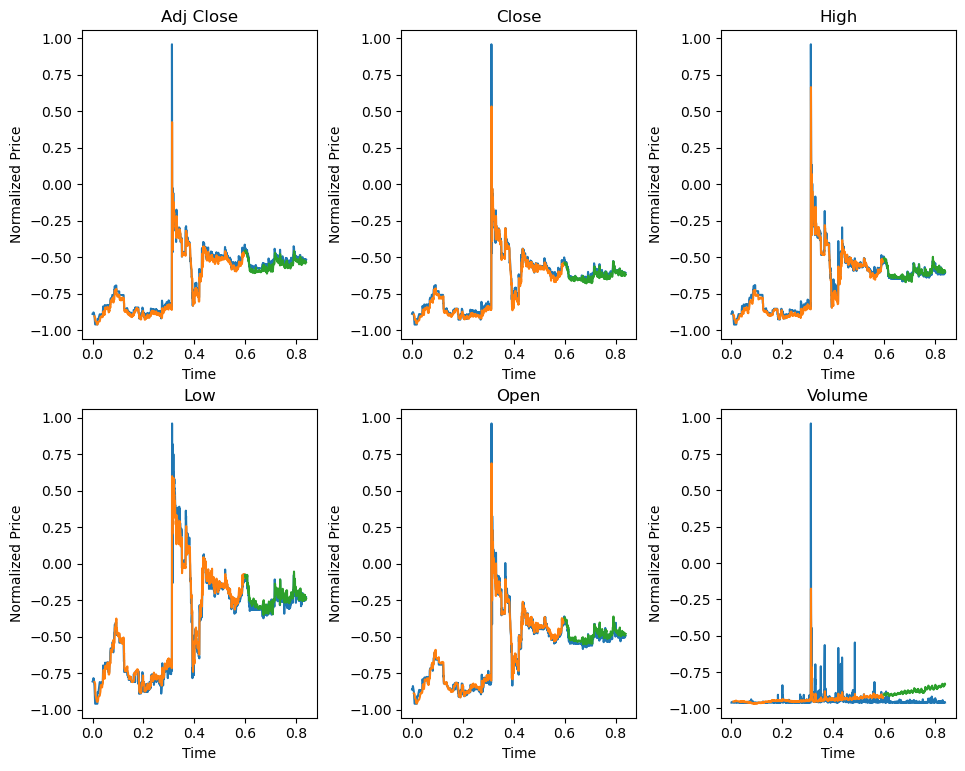

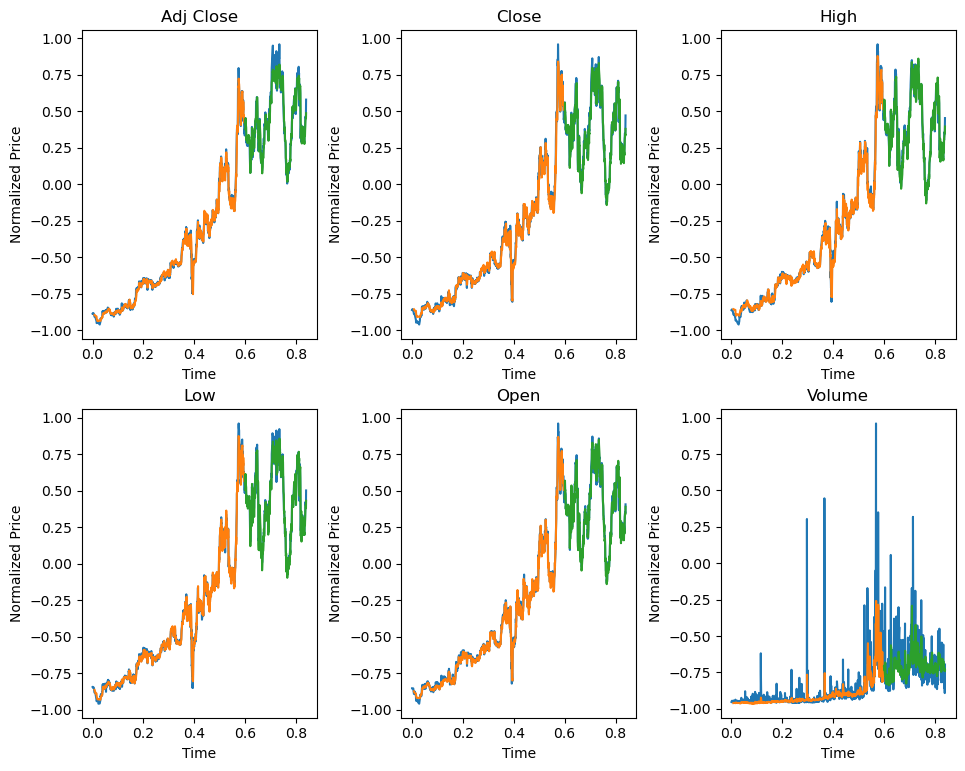

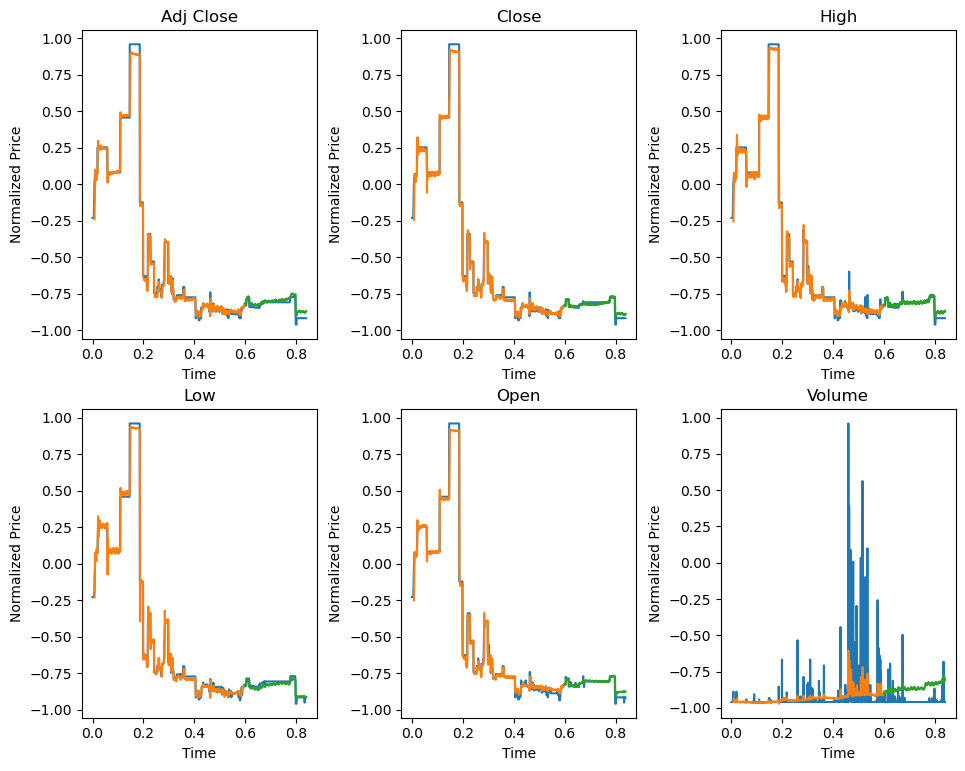

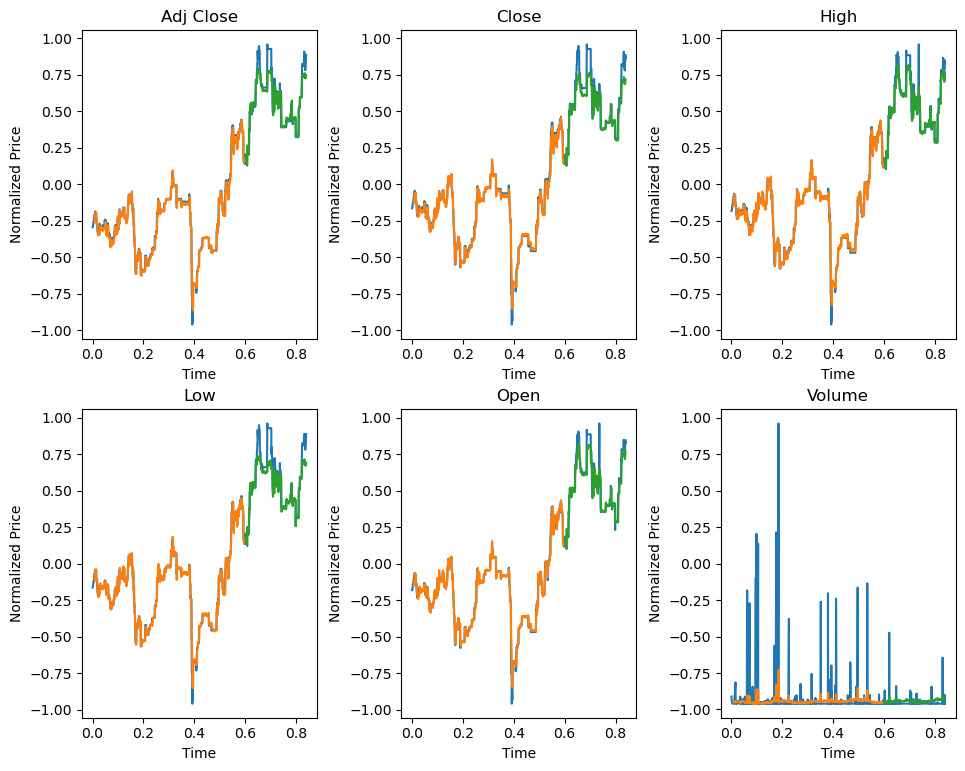

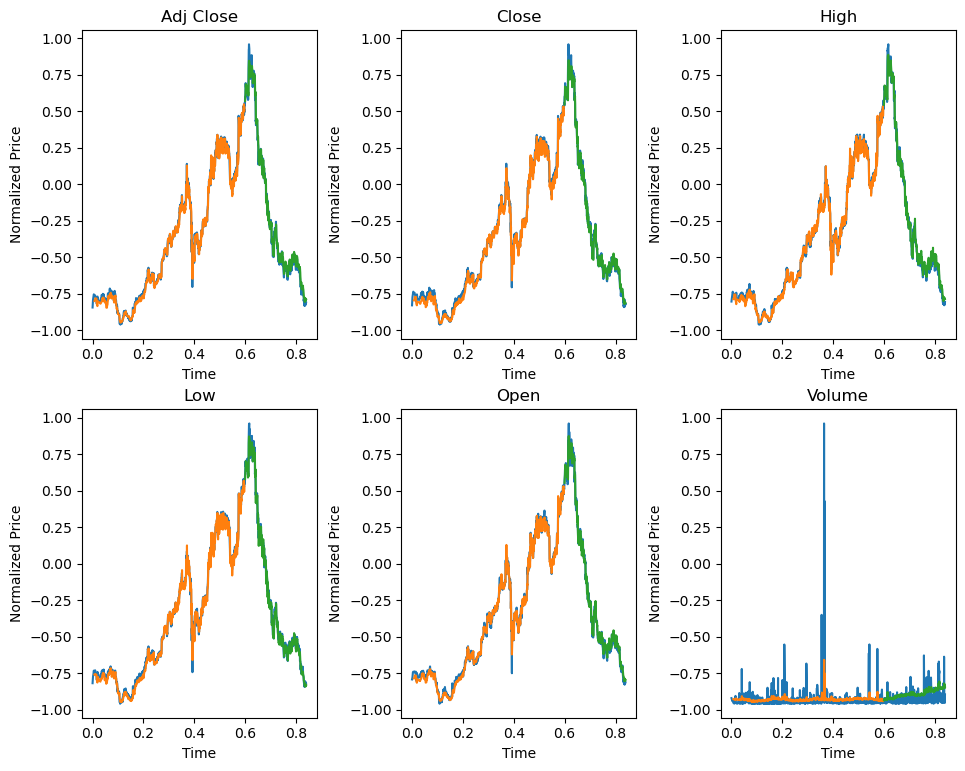

In [87]:
from matplotlib import pyplot as plt

for s in stocks[:5]:
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    fig.tight_layout(pad=3.0)
    for ind in range(6):
        i = ind // 3
        j = ind % 3
        feat = predictFeats[ind]
        
        trPred = trainPredict.loc[s, :]
        tePred = testPredict.loc[s, :]
        
        axs[i, j].plot(dateData['Day'], priceData[(s, feat)])
        axs[i, j].plot(trainDate['Day'].iloc[lookBack:], trPred[feat])
        axs[i, j].plot(testDate['Day'].iloc[lookBack:], tePred[feat])
        axs[i, j].set(xlabel='Time', ylabel='Normalized Price')
        axs[i, j].set_title(feat)
